# Case Study 1

#### Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz 
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of 
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.




In [2]:
import warnings
import csv
import numpy as np
import pandas as pd


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 10000)  # or 1000
pd.set_option('display.max_rows', 10000)  # or 1000
pd.set_option('display.max_colwidth', 10000)  # or 199


from matplotlib import pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, accuracy_score,confusion_matrix
from sklearn import metrics
from sklearn.model_selection import GroupShuffleSplit, LeaveOneGroupOut, KFold
from sklearn.feature_selection import RFE, SelectFromModel, RFECV, SelectKBest, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from collections import Counter
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel

# Load data

In [3]:
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

# Plotting data in 2D with axes sampled 
## a) At random 
## b) From same electrode
## c) From same feature type

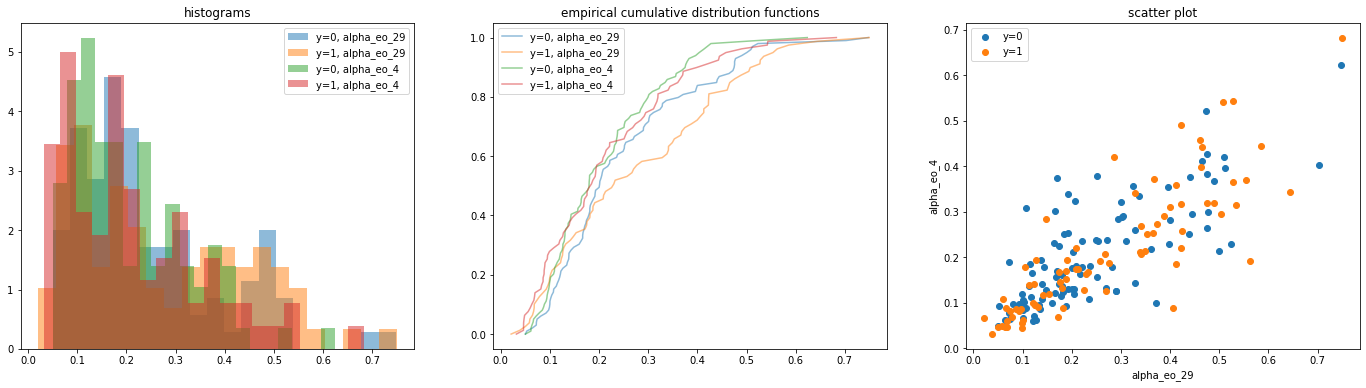

In [4]:
num_features = 9
num_electrodes = 48

# a) indices drawn at random
i0, i1 = np.random.randint(0, X.shape[1], size=2)

#b) same electrode, different feature (uncomment lines below)
f0, f1 = np.random.randint(0, num_features, size=2)
e = np.random.randint(0, num_electrodes)
i0, i1 = f0*num_electrodes + e, f1*num_electrodes + e

#c) same feature, different electrode (uncomment lines below)
f = np.random.randint(0, num_features)
e0, e1 = np.random.randint(0, num_electrodes, size=2)
i0, i1 = f*num_electrodes + e0, f*num_electrodes + e1

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
colors = ['blue', 'red']

# select features i0, i1 and separate by class
X00, X01 = X[y==0][:,i0], X[y==1][:,i0]
X10, X11 = X[y==0][:,i1], X[y==1][:,i1]
# plot cumulative distribution of feature i0 separate for each class
axes[0].hist(X00, bins=20, label='y=0, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X01, bins=20, label='y=1, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X10, bins=20, label='y=0, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].hist(X11, bins=20, label='y=1, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].set_title('histograms')
axes[0].legend()
axes[1].plot(np.sort(X00), np.linspace(0,1,X00.shape[0]), label='y=0, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X01), np.linspace(0,1,X01.shape[0]), label='y=1, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X10), np.linspace(0,1,X10.shape[0]), label='y=0, '+ feature_names[i1], alpha=0.5)
axes[1].plot(np.sort(X11), np.linspace(0,1,X11.shape[0]), label='y=1, '+ feature_names[i1], alpha=0.5)
axes[1].set_title('empirical cumulative distribution functions')
axes[1].legend()
axes[2].scatter(X00, X10, label='y=0')
axes[2].scatter(X01, X11, label='y=1')
axes[2].set_xlabel(feature_names[i0])
axes[2].set_ylabel(feature_names[i1])
axes[2].set_title('scatter plot')
axes[2].legend()

# Defining Models and Cross Validation Scheme

In [5]:
models = [
          ('LogReg', LogisticRegression()), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('GNB', GaussianNB()),
        ]

clf = SVC(kernel='linear')
kf = KFold(n_splits=18, shuffle=False)

# Evaluation Function

In [6]:
def evaluate(models, data, kf):
    result_list = []
    for name, model in models:
        sens, spec, acc = [],[],[]
        y_true, y_pred = [],[]

        for train_index, test_index in kf.split(data):
            X_train, X_test = data[train_index], data[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model.fit(X_train,y_train)
            y_predict = model.predict(X_test)

            y_pred.append(y_predict)
            y_true.append(y_test)

            acc.append(accuracy_score(y_test, y_predict))

        flat_y_true = []
        for sublist in y_true:
            for item in sublist:
                flat_y_true.append(item)

        flat_y_pred = []
        for sublist in y_pred:
            for item in sublist:
                flat_y_pred.append(item)

        y_true = flat_y_true
        y_pred = flat_y_pred

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)

        result_dict = {}
        result_dict["model"] = name
        result_dict["accuracy"] = np.mean(acc)
        result_dict["specificity"] = tn / (tn+fp)
        result_dict["sensitivity"] = tp / (tp+fn)
        result_dict["auc"] = auc(fpr, tpr)
        result_list.append(result_dict)

    results = pd.DataFrame.from_dict(result_list)
    return results

# Baseline Benchmark.

In [7]:
results = evaluate(models, X, kf)
results

,model,accuracy,specificity,sensitivity,auc
0,LogReg,0.855556,0.88,0.8250,0.85250
1,RF,0.838889,0.89,0.7750,0.83250
2,KNN,0.688889,0.77,0.5875,0.67875
3,SVM,0.661111,0.64,0.6875,0.66375
4,GNB,0.750000,0.82,0.6625,0.74125


In [8]:
#classifier Logistic Regression as base classifier
lreg = LogisticRegression()
feature_names = np.genfromtxt('feature_names.csv', delimiter=',', dtype='str')

In [136]:
#Forward Feature Selection
#with 100 features, performance on average degraded except for RF
#with 200 features, performance on average degraded except for RF
#with 250 features, performance on average close to benchmark
#with 300 features, performance on average slightly better than benchmark
sfs = SequentialFeatureSelector(lreg, n_features_to_select=322, direction='forward', n_jobs=-1)
sfs.fit(X, y)

SequentialFeatureSelector(estimator=LogisticRegression(),
                          n_features_to_select=300, n_jobs=-1)

In [137]:
X_subset = sfs.transform(X)
X_subset.shape

(180, 300)

In [138]:
results = evaluate(models, X_subset, kf)
results

,model,accuracy,specificity,sensitivity,auc
0,LogReg,0.872222,0.93,0.8000,0.86500
1,RF,0.838889,0.91,0.7500,0.83000
2,KNN,0.722222,0.76,0.6750,0.71750
3,SVM,0.605556,0.74,0.4375,0.58875
4,GNB,0.683333,0.84,0.4875,0.66375


In [132]:
#Backward Feature Selection
#with 250 features, BFS performance close to benchmark
sfs = SequentialFeatureSelector(lreg, n_features_to_select=250, direction='backward', n_jobs=-1)
sfs.fit(X, y)

SequentialFeatureSelector(direction='backward', estimator=LogisticRegression(),
                          n_features_to_select=250, n_jobs=-1)

In [133]:
X_subset = sfs.transform(X)
X_subset.shape

(180, 250)

In [134]:
results = evaluate(models, X_subset, kf)
results

,model,accuracy,specificity,sensitivity,auc
0,LogReg,0.844444,0.86,0.8250,0.84250
1,RF,0.816667,0.86,0.7625,0.81125
2,KNN,0.677778,0.74,0.6000,0.67000
3,SVM,0.688889,0.66,0.7250,0.69250
4,GNB,0.738889,0.83,0.6250,0.72750


In [28]:
#Recursive Feature Elemenation with cross-validated selection of best features
rfe = RFECV(lreg, step=1, cv=kf.split(X), scoring='f1', n_jobs=-1)
rfe = rfe.fit(X, y)
# from sklearn import metrics
# sorted(metrics.SCORERS.keys())

In [29]:
print('Number of features: ',rfe.n_features_)
print('Ranking: ',rfe.ranking_)
print('Selected Features: ', feature_names[rfe.support_])

Number of features:  43
Ranking:  [354 307 275 168 169  36  66 165 375 381 186  60 103 374 258 348  33  87
 199 236 341 104 161 121 310  70 377 296 237 263 116   1 268 293 368 349
 308 350 257   9 228  88  65 352  98  57 301 360 304 262 272 217 204  73
 139 212 384 357 285  46  93 230 164 358 290 276 190 242 271 378   1 332
 286 241  61 229 333 292 244 216 303 325 273 382 376 383 385 234 156 284
 297 371 369 366 298 386 114 122  84 170 323 300 246 209 154 123 255 227
 213 215 172 231 147 146 149 153  74 105 174 291 322  41  97 115  91 110
 141 183   8  39  94 188 181 173 211 269 280 125 239 315 185 345 388 225
 270 337 171   1 367 218 191 279 373  16 135 184 342 330  81 207 248 193
 222 282 334 120 132 319 137 232 278 283 312 223 287   3 245 219  44 192
 138 155 362 178  89  67  79 233 288 317 311 379  95  47 162  37 226 309
 321 361 344 320 347 247 305 372  28 107 370  69 112 389 240 202   1 289
 189  40   1  90 306 144 140 267 318 196   1 134 250 235 260 274 145 180
 281 364 326 201 

In [33]:
X_subset = rfe.transform(X)
X_subset.shape

(180, 43)

In [34]:
#with 43 features, RFECV significantly improved the performance of Logistic Regression
results = evaluate(models, X_subset, kf)
results

,model,accuracy,specificity,sensitivity,auc
0,LogReg,0.933333,0.92,0.9500,0.93500
1,RF,0.783333,0.84,0.7125,0.77625
2,KNN,0.694444,0.71,0.6750,0.69250
3,SVM,0.727778,0.67,0.8000,0.73500
4,GNB,0.761111,0.89,0.6000,0.74500


In [37]:
#Model-based feature selection (Embedded methods)
#LassoCV
sfm = SelectFromModel(estimator=LassoCV()).fit(X, y)
coefs = sfm.estimator_.coef_
coefs[sfm.get_support()]

array([ 1.68873771e-01, -9.22081800e-01,  2.59938695e-01, -8.10073507e-01,
        1.14174691e-01,  5.05357278e-01,  5.05139071e-02,  4.84936934e-01,
        4.09162858e-01,  5.88173760e-01,  1.00113626e+00,  4.02592076e-01,
       -3.28161375e-01, -3.81704306e-01, -9.03654585e-01,  3.05603507e-01,
        2.48980141e-01,  6.39874741e-01,  1.65713736e-01, -8.63440139e-02,
        3.08881406e-02,  2.97503821e-02,  8.87520073e-02, -3.23251620e-03,
        1.21963562e-01, -8.35264450e-03,  2.02145616e-02, -8.00688346e-02,
        4.46329788e-02, -4.18378045e-02, -5.93023739e-02,  3.40215786e-02,
        2.85672160e-02,  1.93856180e-02,  1.14590937e-02, -5.08195749e-02,
        1.68692797e-02, -4.97655582e-02, -8.87953844e-02, -2.44132572e-02,
       -9.50285220e-02,  1.09357003e-01,  2.54026741e-02, -9.25995315e-03,
        8.92120111e-02,  6.17396161e-02,  2.88645073e-02, -4.81576833e-02,
        9.20382979e-02,  1.01528036e-04, -8.71559741e-04, -1.37434822e-02,
       -1.05073760e-01,  

In [51]:
print(sfm.threshold_)
len(feature_names[sfm.get_support()])

1e-05


107

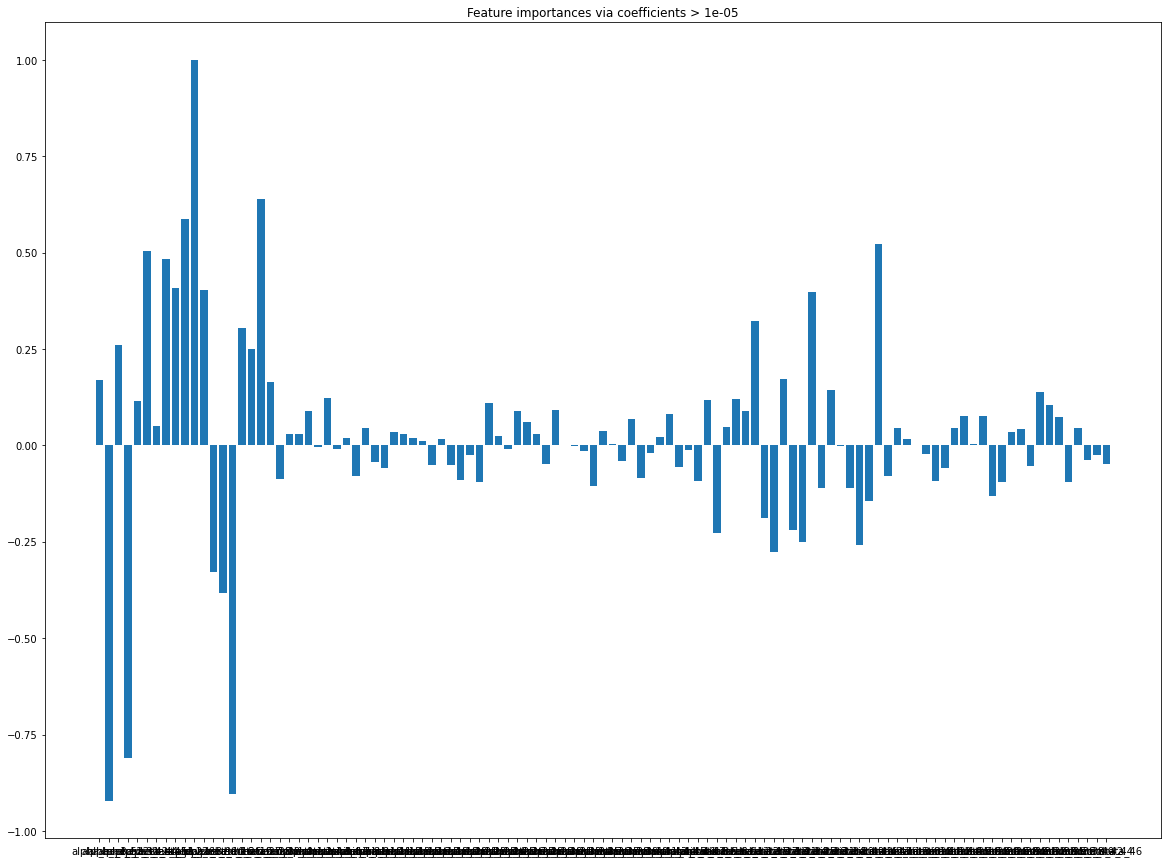

In [50]:
plt.figure(figsize=(20,15))
plt.bar(height=coefs[sfm.get_support()], x=feature_names[sfm.get_support()])
plt.title(f"Feature importances via coefficients > {sfm.threshold_}")
plt.show()

In [52]:
X_subset = sfm.transform(X)
X_subset.shape

(180, 107)

In [53]:
#with 107 features, performance with LassoCV as feature selection model is close to benchmark
results = evaluate(models, X_subset, kf)
results

,model,accuracy,specificity,sensitivity,auc
0,LogReg,0.850000,0.87,0.8250,0.84750
1,RF,0.794444,0.85,0.7250,0.78750
2,KNN,0.650000,0.72,0.5625,0.64125
3,SVM,0.616667,0.57,0.6750,0.62250
4,GNB,0.738889,0.85,0.6000,0.72500


In [54]:
#Logistic Regression
sfm = SelectFromModel(estimator=lreg).fit(X, y)

In [55]:
coefs = sfm.estimator_.coef_[0]
coefs[sfm.get_support()]

array([-0.28756721, -0.23261503, -0.24503963, -0.19794102, -0.26460826,
       -0.23771013, -0.19187812, -0.25904834, -0.21207729, -0.49691532,
       -0.27813623,  0.23432033,  0.25769901,  0.21306044,  0.23996204,
        0.250332  ,  0.1875295 ,  0.27725667,  0.23093302, -0.2637576 ,
       -0.19640817,  0.19139085,  0.20371424,  0.18822817,  0.22651748,
        0.18505822,  0.18375857,  0.18258583,  0.23732324,  0.22360875,
        0.17889645,  0.38607103,  0.32194439,  0.19206848, -0.29905809,
        0.21215906, -0.19182329,  0.21348271,  0.25079355, -0.17808491,
       -0.18007481, -0.20308764, -0.1835958 , -0.27203473, -0.18750279,
       -0.37284094, -0.18642243, -0.27611326,  0.18593421,  0.19505384,
       -0.20028989,  0.18970107,  0.23077656,  0.22327403,  0.19854732,
        0.19322309,  0.21826948,  0.20756792,  0.22432899,  0.21134102,
        0.17838034,  0.23455335,  0.27387139,  0.20070556,  0.23180535,
        0.19461555, -0.28104487, -0.26199382, -0.32803028, -0.90

In [56]:
print(sfm.threshold_)
len(feature_names[sfm.get_support()])

0.17747166683344423


166

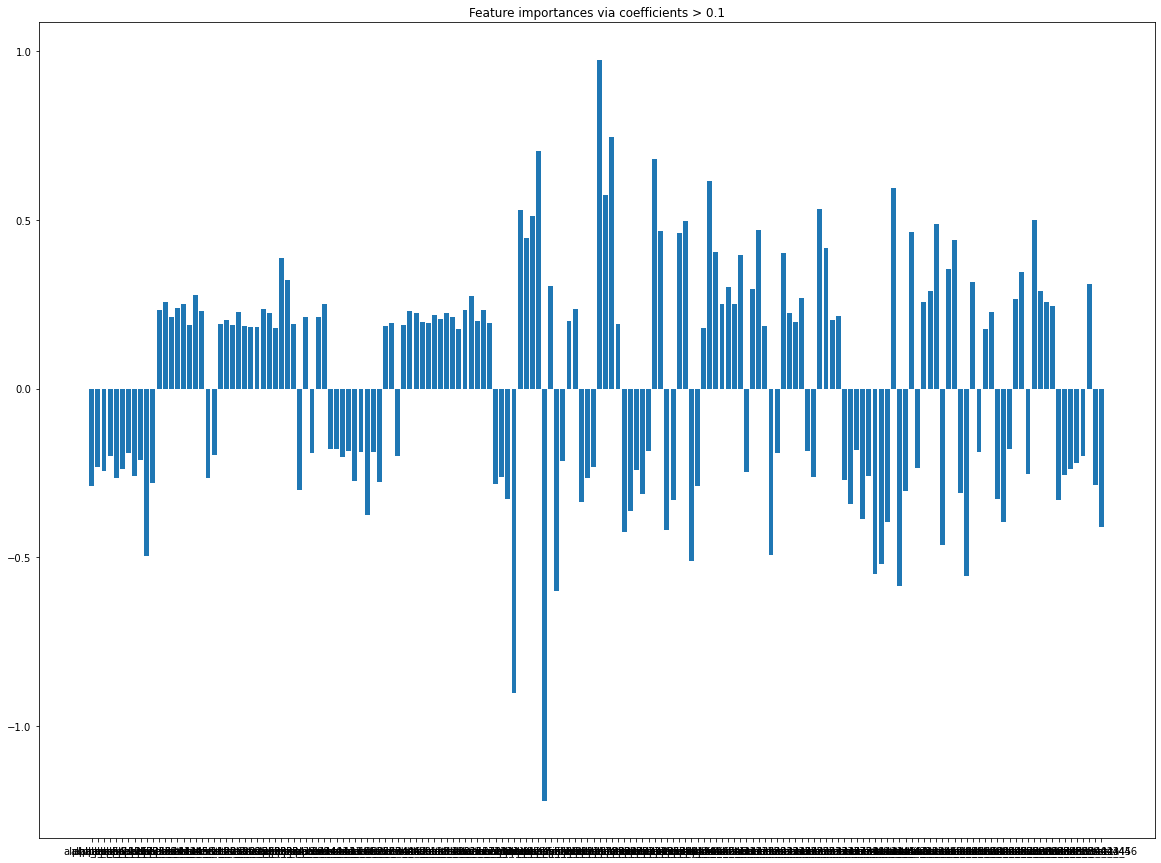

In [57]:
plt.figure(figsize=(20,15))
plt.bar(height=coefs[sfm.get_support()], x=feature_names[sfm.get_support()])
plt.title("Feature importances via coefficients > 0.1")
plt.show()

In [58]:
X_subset = sfm.transform(X)
X_subset.shape

(180, 166)

In [59]:
#with 166 features, model based selection with logistic regression shows improvement over other methods
results = evaluate(models, X_subset, kf)
results

,model,accuracy,specificity,sensitivity,auc
0,LogReg,0.877778,0.90,0.8500,0.87500
1,RF,0.838889,0.87,0.8000,0.83500
2,KNN,0.727778,0.77,0.6750,0.72250
3,SVM,0.705556,0.66,0.7625,0.71125
4,GNB,0.777778,0.86,0.6750,0.76750
